# 1. 数据探索

## 1.1 train_users_2和test_users文件

In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline
import datetime
import os
import seaborn as sns#数据可视化
from datetime import date
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
import pickle #用于存储模型
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import *

train = pd.read_csv("airbnb/train_users_2.csv")
test = pd.read_csv("airbnb/test_users.csv")

In [235]:
# 查看数据信息，date_first_booking缺失较多考虑删除
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB
<class 'pandas.core.frame.D

In [236]:
# 'date_first_booking'在测试集中全为空，故删除该特征
del train['date_first_booking']
del test['date_first_booking']

In [237]:
# 'first_affiliate_tracked'用出现最多的'untracked'补充缺失值
train.groupby('first_affiliate_tracked').count().sort_values('id',ascending=False)
# train['gender'].value_counts()，记录各种类数量
train['first_affiliate_tracked'].fillna('untracked',inplace=True)
test.groupby('first_affiliate_tracked').count().sort_values('id',ascending=False)
# test['gender'].value_counts()，记录各种类数量
test['first_affiliate_tracked'].fillna('untracked',inplace=True)

In [238]:
# 'gender'统一，将other记为-unknown-
train['gender'].unique()
train.loc[train['gender']=='OTHER','gender']='-unknown-'
test.loc[test['gender']=='OTHER','gender']='-unknown-'

In [239]:
# 'age'异常值处理
train['age']=train['age'].apply(lambda x:np.nan if x>120 or x<0 else x)
test['age']=test['age'].apply(lambda x:np.nan if x>120 or x<0 else x)

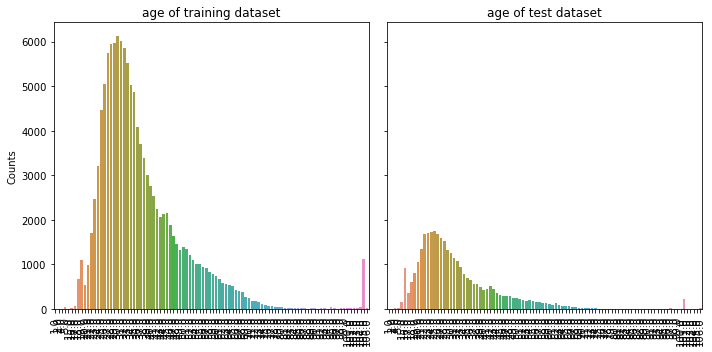

In [240]:
# 用柱状图统计各个特征情况
def feature_barplot(feature, df_train = train, df_test = test, figsize=(10,5), rot = 90, saveimg = False): 
    feat_train = df_train[feature].value_counts()
    feat_test = df_test[feature].value_counts()
    fig_feature, (axis1,axis2) = plt.subplots(1,2,sharex=True, sharey = True, figsize = figsize)
    sns.barplot(feat_train.index.values, feat_train.values, ax = axis1)
    sns.barplot(feat_test.index.values, feat_test.values, ax = axis2)
    axis1.set_xticklabels(axis1.xaxis.get_majorticklabels(), rotation = rot)
    axis2.set_xticklabels(axis1.xaxis.get_majorticklabels(), rotation = rot)
    axis1.set_title(feature + ' of training dataset')
    axis2.set_title(feature + ' of test dataset')
    axis1.set_ylabel('Counts')
    plt.tight_layout()
    if saveimg == True:
        figname = feature + ".png"
        fig_feature.savefig(figname, dpi = 75)
feature_barplot('age')

In [241]:
# age 缺失值，离散化
def simplify_ages(df):
    df['age'] = df['age'].fillna(-0.5)
    # 把Age分为不同区间,-1到0,0-3,3-12...,60及以上,放到bins里，八个区间，对应的八个区间名称在group_names那
    bins = [-1, 0, 10, 20, 30, 40, 50, 60, 120]
    group_names = ['Unknown', '[0,10)', '[10,20)', '[20,30)', '[30,40)', '[40,50)', '[50,60)','[60,120]']
    # 开始对数据进行离散化，pandas.cut就是这个功能
    catagories = pd.cut(df['age'], bins, labels=group_names,right=False)
    df['age'] = catagories
    #print(catagories.value_counts())
    return df
train=simplify_ages(train)
test=simplify_ages(test)

In [242]:
# 重复值处理，无重复值
print(len(train['id'].unique()))
print(train['id'].count())
print(len(test['id'].unique()))
print(test['id'].count())

213451
213451
62096
62096


## 1.2 session文件

In [17]:
session = pd.read_csv('airbnb/sessions.csv')
session.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
user_id          object
action           object
action_type      object
action_detail    object
device_type      object
secs_elapsed     float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [18]:
session['action'].isnull().sum()
session['action'].fillna('-unknown-',inplace=True)
session['action_type'].isnull().sum()
session['action_type'].fillna('-unknown-',inplace=True)
session['action_detail'].isnull().sum()
session['action_detail'].fillna('-unknown-',inplace=True)
session['secs_elapsed'].isnull().sum()/len(session['secs_elapsed'])
session['secs_elapsed'].fillna(0,inplace=True)

# 2. 特征提取

## 2.1 session文件

In [19]:
# 更好合并
session['id'] = session['user_id']
del session['user_id']

In [20]:
# 对action特征进行细化
f_act = session['action'].value_counts().argsort() # argsort函数返回的是数组值从小到大的索引值
f_act_detail = session['action_detail'].value_counts().argsort()
f_act_type = session['action_type'].value_counts().argsort()
f_dev_type = session['device_type'].value_counts().argsort()

In [14]:
# 按照id进行分组
dgr_sess = session.groupby(['id'])
# Loop on dgr_sess to create all the features.
samples = []  # samples列表
ln = len(dgr_sess)  # 计算分组后df_sessions的长度
k=1

In [15]:
def session_feature():
        global k
        for g in dgr_sess:  # 对dgr_sess中每个id的数据进行遍历
            gr = g[1]  # data frame that comtains all the data for a groupby value 'zzywmcn0jv'

            l = []  # 建一个空列表，临时存放特征

            # the id    for example:'zzywmcn0jv'
            l.append(g[0])  # 将id值放入空列表中

            # number of total actions
            l.append(len(gr))  # 将id对应数据的长度放入列表

            # action features 特征-用户行为
            # 每个用户行为出现的次数，各个行为类型的数量，平均值以及标准差
            c_act = [0] * len(f_act)
            for i, v in enumerate(gr.action.values):  # i是从0-1对应的位置，v 是用户行为特征的值
                c_act[f_act[v]] += 1
            _, c_act_uqc = np.unique(gr.action.values, return_counts=True)
            # 计算用户行为行为特征各个类型数量的长度，平均值以及标准差
            c_act += [len(c_act_uqc), np.mean(c_act_uqc), np.std(c_act_uqc)]
            l = l + c_act

            # action_detail features 特征-用户行为具体
            # (how many times each value occurs, numb of unique values, mean and std)
            c_act_detail = [0] * len(f_act_detail)
            for i, v in enumerate(gr.action_detail.values):
                c_act_detail[f_act_detail[v]] += 1
            _, c_act_det_uqc = np.unique(gr.action_detail.values, return_counts=True)
            c_act_detail += [len(c_act_det_uqc), np.mean(c_act_det_uqc), np.std(c_act_det_uqc)]
            l = l + c_act_detail

            # action_type features  特征-用户行为类型 click等
            # (how many times each value occurs, numb of unique values, mean and std
            # + log of the sum of secs_elapsed for each value)
            l_act_type = [0] * len(f_act_type)
            c_act_type = [0] * len(f_act_type)
            sev = gr.secs_elapsed.values
            for i, v in enumerate(gr.action_type.values):
                l_act_type[f_act_type[v]] += sev[i]  # sev = gr.secs_elapsed.fillna(0).values ，求每个行为类型总的停留时长
                c_act_type[f_act_type[v]] += 1
            l_act_type = np.log(1 + np.array(l_act_type)).tolist()  # 每个行为类型总的停留时长，差异比较大，进行log处理
            _, c_act_type_uqc = np.unique(gr.action_type.values, return_counts=True)
            c_act_type += [len(c_act_type_uqc), np.mean(c_act_type_uqc), np.std(c_act_type_uqc)]
            l = l + c_act_type + l_act_type

            # device_type features 特征-设备类型
            # (how many times each value occurs, numb of unique values, mean and std)
            c_dev_type = [0] * len(f_dev_type)
            for i, v in enumerate(gr.device_type.values):
                c_dev_type[f_dev_type[v]] += 1
            c_dev_type.append(len(np.unique(gr.device_type.values)))
            _, c_dev_type_uqc = np.unique(gr.device_type.values, return_counts=True)
            c_dev_type += [len(c_dev_type_uqc), np.mean(c_dev_type_uqc), np.std(c_dev_type_uqc)]
            l = l + c_dev_type

            # secs_elapsed features  特征-停留时长
            l_secs = [0] * 5
            l_log = [0] * 15
            if len(sev) > 0:
                # Simple statistics about the secs_elapsed values.
                l_secs[0] = np.log(1 + np.sum(sev))
                l_secs[1] = np.log(1 + np.mean(sev))
                l_secs[2] = np.log(1 + np.std(sev))
                l_secs[3] = np.log(1 + np.median(sev))
                l_secs[4] = l_secs[0] / float(l[1])  #

                # Values are grouped in 15 intervals. Compute the number of values
                # in each interval.
                # sev = gr.secs_elapsed.fillna(0).values
                log_sev = np.log(1 + sev).astype(int)
                # np.bincount():Count number of occurrences of each value in array of non-negative ints.
                l_log = np.bincount(log_sev, minlength=15).tolist()
                print("\r进度：%.2f%%" % (float(k / len(dgr_sess) * 100)), end=' ')
                k=k+1
            l = l + l_secs + l_log

            # The list l has the feature values of one sample.
            samples.append(l)
        print("\n")
session_feature()

进度：100.00%                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [18]:
# preparing objects
samples = np.array(samples)
samp_ar = samples[:, 1:].astype(np.float16)  # 取除id外的特征数据
samp_id = samples[:, 0]  # 取id，id位于第一列

# 为提取的特征创建一个dataframe
col_names = []  # name of the columns
for i in range(len(samples[0]) - 1):  # 减1的原因是因为有个id
    col_names.append('c_' + str(i))  # 起名字的方式
df_agg_sess = pd.DataFrame(samp_ar, columns=col_names)
df_agg_sess['id'] = samp_id
df_agg_sess.index = df_agg_sess.id  # 将id作为index
#经过特征提取后，session文件由6个特征变为584个特征

## 2.2 trian和test文件进行特征提取

In [243]:
#计算出train的行数，便于之后对train和test数据进行分离操作
train_row = train.shape[0]
# 预测值放入labels
labels = train['country_destination'].values

In [244]:
# 删除预测值的列
del train['country_destination']
# 合并，连接test 和 train，采用上下拼接
df = pd.concat([train, test], axis = 0, ignore_index = True)

In [245]:
# timestamp_first_active特征
# 转换为datetime类型
tfa = df.timestamp_first_active.astype(str).apply(lambda x: datetime.datetime(int(x[:4]),
                                                                          int(x[4:6]), 
                                                                          int(x[6:8]),
                                                                          int(x[8:10]),
                                                                          int(x[10:12]),
                                                                          int(x[12:])))

# datetime类对象有year，month，day等属性
df['tfa_year'] = np.array([x.year for x in tfa])
df['tfa_month'] = np.array([x.month for x in tfa])
df['tfa_day'] = np.array([x.day for x in tfa])
# 提取特征weekday
# isoweekday() 可以返回一周的星期几，e.g.星期日：0；星期一：1
df['tfa_wd'] = np.array([x.isoweekday() for x in tfa]) 
df_tfa_wd = pd.get_dummies(df.tfa_wd, prefix = 'tfa_wd')  # one hot encoding 独热编码
df = pd.concat((df, df_tfa_wd), axis = 1) #添加df['tfa_wd'] 编码后的特征
df.drop(['tfa_wd'], axis = 1, inplace = True)#删除原有未编码的特征
# 提取特征季节
Y = 2000
seasons = [(0, (date(Y,  1,  1),  date(Y,  3, 20))),  #'winter'
           (1, (date(Y,  3, 21),  date(Y,  6, 20))),  #'spring'
           (2, (date(Y,  6, 21),  date(Y,  9, 22))),  #'summer'
           (3, (date(Y,  9, 23),  date(Y, 12, 20))),  #'autumn'
           (0, (date(Y, 12, 21),  date(Y, 12, 31)))]  #'winter'

def get_season(dt):
    dt = dt.date() #获取日期
    dt = dt.replace(year=Y) #将年统一换成2000年
    return next(season for season, (start, end) in seasons if start <= dt <= end)

df['tfa_season'] = np.array([get_season(x) for x in tfa])
df_tfa_season = pd.get_dummies(df.tfa_season, prefix = 'tfa_season') # one hot encoding 独热编码
df = pd.concat((df, df_tfa_season), axis = 1)
df.drop(['tfa_season'], axis = 1, inplace = True) # 删除原来列

In [246]:
# date_account_created特征提取
# 将date_account_created转换为datetime类型
dac = pd.to_datetime(df.date_account_created)
# 提取年月日
df['dac_year'] = np.array([x.year for x in dac])
df['dac_month'] = np.array([x.month for x in dac])
df['dac_day'] = np.array([x.day for x in dac])
# 提取季节
df['dac_season'] = np.array([get_season(x) for x in dac])
df_dac_season = pd.get_dummies(df.dac_season, prefix = 'dac_season')
df = pd.concat((df, df_dac_season), axis = 1)
df.drop(['dac_season'], axis = 1, inplace = True)

In [247]:
# 提取用户在airbnb平台活跃到正式注册所花的时间，即date_account_created和timestamp_first_active之间的差值
dt_span = dac.subtract(tfa).dt.days
dt_span.value_counts().head(10)

def get_span(dt):
    # dt is an integer
    if dt == -1:
        return 'OneDay'
    elif (dt < 30) & (dt > -1):
        return 'OneMonth'
    elif (dt >= 30) & (dt <= 365):
        return 'OneYear'
    else:
        return 'other'

df['dt_span'] = np.array([get_span(x) for x in dt_span])
df_dt_span = pd.get_dummies(df.dt_span, prefix = 'dt_span') # 编码 one hot encoding 
df = pd.concat((df, df_dt_span), axis = 1)
df.drop(['dt_span'], axis = 1, inplace = True)

In [248]:
# 删除提取特征后原来的列
df.drop(['date_account_created','timestamp_first_active'], axis = 1, inplace = True)

In [249]:
# 对其余特征进行one hot encoding
feat_toOHE = ['age',
             'gender', 
             'signup_method', 
             'signup_flow', 
             'language', 
             'affiliate_channel', 
             'affiliate_provider', 
             'first_affiliate_tracked', 
             'signup_app', 
             'first_device_type', 
             'first_browser']
for f in feat_toOHE:
    df[f] = pd.get_dummies(df[f], prefix=f, dummy_na=True) # 缺失值单独成一类

## 2.3 整合数据

In [27]:
#将对session提取的特征整合到一起
df_all = pd.merge(df, df_agg_sess, how='left')
df_all = df_all.drop(['id'], axis=1) #删除id
df_all = df_all.fillna(-2)  #对没有sesssion data的特征进行缺失值处理，值为负数说明是空
#加了一列，表示每一行总共有多少空值，这也作为一个特征
df_all['all_null'] = np.array([sum(r<0) for r in df_all.values]) # 值为负即为空值
print(df_all)

        gender  age  signup_method  signup_flow  language  affiliate_channel  \
0            1    1              0            1         0                  0   
1            0    0              0            1         0                  0   
2            0    0              1            0         0                  0   
3            0    0              0            1         0                  0   
4            1    0              1            1         0                  0   
5            1    1              1            1         0                  0   
6            0    0              1            1         0                  0   
7            0    0              1            1         0                  0   
8            0    0              1            1         0                  0   
9            1    0              1            1         0                  0   
10           0    0              1            1         0                  0   
11           0    0              1      

In [252]:
# 不合并session文件
df_all=df
df_id=df_all['id'].values
df_all = df_all.drop(['id'], axis=1) #删除id
df_all = df_all.fillna(-2)  #对没有sesssion data的特征进行缺失值处理，值为负数说明是空
#加了一列，表示每一行总共有多少空值，这也作为一个特征
df_all['all_null'] = np.array([sum(r<0) for r in df_all.values]) # 值为负即为空值

# 3. 模型构建

## 3.1 数据准备

In [261]:
# 将train和test数据进行分离操作
Xtrain = df_all.iloc[:train_row, :]
Xtest = df_all.iloc[train_row:, :]
testlabels = df_id[train_row:]

(62096, 37)
(62096,)


D:\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 4 36] are constant.
  UserWarning)
D:\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


([<matplotlib.axis.XTick at 0x22085f10808>,
 [Text(0, 0, 'gender'),
  Text(0, 0, 'age'),
  Text(0, 0, 'signup_method'),
  Text(0, 0, 'signup_flow'),
  Text(0, 0, 'language'),
  Text(0, 0, 'affiliate_channel'),
  Text(0, 0, 'affiliate_provider'),
  Text(0, 0, 'first_affiliate_tracked'),
  Text(0, 0, 'signup_app'),
  Text(0, 0, 'first_device_type'),
  Text(0, 0, 'first_browser'),
  Text(0, 0, 'tfa_year'),
  Text(0, 0, 'tfa_month'),
  Text(0, 0, 'tfa_day'),
  Text(0, 0, 'tfa_wd_1'),
  Text(0, 0, 'tfa_wd_2'),
  Text(0, 0, 'tfa_wd_3'),
  Text(0, 0, 'tfa_wd_4'),
  Text(0, 0, 'tfa_wd_5'),
  Text(0, 0, 'tfa_wd_6'),
  Text(0, 0, 'tfa_wd_7'),
  Text(0, 0, 'tfa_season_0'),
  Text(0, 0, 'tfa_season_1'),
  Text(0, 0, 'tfa_season_2'),
  Text(0, 0, 'tfa_season_3'),
  Text(0, 0, 'dac_year'),
  Text(0, 0, 'dac_month'),
  Text(0, 0, 'dac_day'),
  Text(0, 0, 'dac_season_0'),
  Text(0, 0, 'dac_season_1'),
  Text(0, 0, 'dac_season_2'),
  Text(0, 0, 'dac_season_3'),
  Text(0, 0, 'dt_span_OneDay'),
  Text(0,

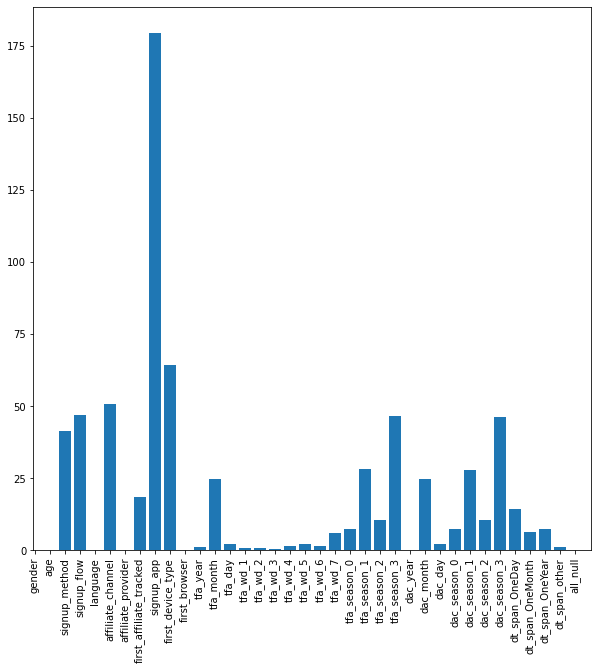

In [85]:
# 特征选择
from sklearn.feature_selection import SelectKBest,f_classif

plt.figure(figsize=(10,10))
selector=SelectKBest(f_classif,k=5)
selector.fit(Xtrain,labels)
scores=-np.log10(selector.pvalues_)
plt.bar(range(len(Xtrain.columns)),scores)
plt.xticks(range(len(Xtrain.columns)),Xtrain.columns,rotation='vertical')

In [87]:
deletes=['all_null','dac_year','first_browser','affiliate_provider','language']
df_all.drop(deletes,axis=1,inplace=True)
# 将train和test数据进行分离操作
Xtrain = df_all.iloc[:train_row, :]
Xtest = df_all.iloc[train_row:, :]

In [19]:
# 将提取的特征生成csv文件
Xtrain.to_csv("Airbnb_xtrain_v2.csv")
Xtest.to_csv("Airbnb_xtest_v2.csv")
#labels.tofile（）：Write array to a file as text or binary (default)
labels.tofile("Airbnb_ytrain_v2.csv", sep='\n', format='%s') #存放目标变量

In [20]:
# 读取特征文件
xtrain = pd.read_csv("Airbnb_xtrain_v2.csv",index_col=0)
ytrain = pd.read_csv("Airbnb_ytrain_v2.csv", header=None)
xtrain.head()
ytrain.head()
print(ytrain[0].value_counts())

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: 0, dtype: int64


In [21]:
# 将目标变量进行labels encoding
le = LabelEncoder()
ytrain_le = le.fit_transform(ytrain)

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [207]:
# 提取30%的数据进行模型训练
# Let us take 10% of the data for faster training. 
n = int(xtrain.shape[0]*0.3)
xtrain_new = xtrain.iloc[:n, :]  #训练数据
ytrain_new = ytrain_le[:n]       #训练数据的目标变量

In [208]:
# 标准化数据集
X_scaler = StandardScaler()
xtrain_new = X_scaler.fit_transform(xtrain_new)

In [209]:
# 评分模型
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    """
    y_true : array, shape = [n_samples] #数据
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes] #预测的分数
        Predicted scores.
    k : int
    """
    order = np.argsort(y_score)[::-1] #分数从小到大的索引号
    y_true = np.take(y_true, order[:k]) #取出前k[0,k）个分数索引号
    
    gain = 2 ** y_true - 1   

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):   
    """
    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities. 预测的概率
    k : int
        Rank.
    """
    # 标签二值化
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)
    scores = []
    # 迭代每个真实值并计算dcg分数
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)
    return np.mean(scores)

## 3.2 树模型

In [210]:
# 树模型
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import *
from sklearn.svm import SVC, LinearSVC, NuSVC
LEARNING_RATE = 0.1
N_ESTIMATORS = 50
RANDOM_STATE = 2017
MAX_DEPTH = 9
k_ndcg = 5

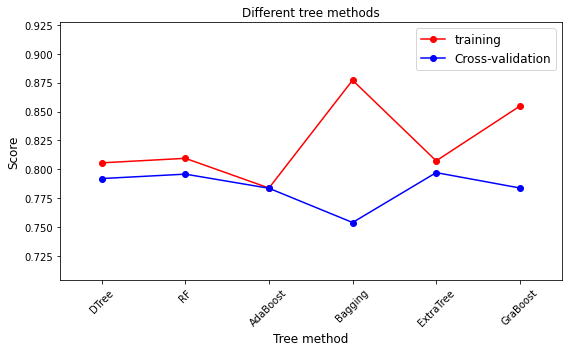

In [60]:
#建了一个tree字典
clf_tree ={
    'DTree': DecisionTreeClassifier(max_depth=MAX_DEPTH,
                                    random_state=RANDOM_STATE),
    
    'RF': RandomForestClassifier(n_estimators=N_ESTIMATORS,
                                 max_depth=MAX_DEPTH,
                                 random_state=RANDOM_STATE),
    
    'AdaBoost': AdaBoostClassifier(n_estimators=N_ESTIMATORS,
                                   learning_rate=LEARNING_RATE,
                                   random_state=RANDOM_STATE),
    
    'Bagging': BaggingClassifier(n_estimators=N_ESTIMATORS,
                                 random_state=RANDOM_STATE),
    
    'ExtraTree': ExtraTreesClassifier(max_depth=MAX_DEPTH,
                                      n_estimators=N_ESTIMATORS,
                                      random_state=RANDOM_STATE),
    
    'GraBoost': GradientBoostingClassifier(learning_rate=LEARNING_RATE,
                                           max_depth=MAX_DEPTH,
                                           n_estimators=N_ESTIMATORS,
                                           random_state=RANDOM_STATE)
}
train_score = []
cv_score = []

kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

k_ndcg = 5

for key in clf_tree.keys():
    
    clf = clf_tree.get(key)
    
    train_score_iter = []
    cv_score_iter = []

    for train_index, test_index in kf.split(xtrain_new, ytrain_new):
        # 训练集分成训练和验证
        X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :]
        y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]
        # 训练模型
        clf.fit(X_train, y_train)
        # 预测结果并评估
        y_pred = clf.predict_proba(X_test)
        train_ndcg_score = ndcg_score(y_train, clf.predict_proba(X_train), k = k_ndcg)
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)
        # 评估结果保存，最后要取平均值作为总评估分数
        train_score_iter.append(train_ndcg_score)
        cv_score_iter.append(cv_ndcg_score)
    # 每种算法的评估分数均保存
    train_score.append(np.mean(train_score_iter))
    cv_score.append(np.mean(cv_score_iter))

train_score_tree = train_score
cv_score_tree = cv_score

ymin = np.min(cv_score)-0.05
ymax = np.max(train_score)+0.05

x_ticks = clf_tree.keys()

plt.figure(figsize=(8,5))
plt.plot(range(len(x_ticks)), train_score_tree, 'ro-', label = 'training')
plt.plot(range(len(x_ticks)), cv_score_tree, 'bo-', label = 'Cross-validation')

plt.xticks(range(len(x_ticks)),x_ticks,rotation = 45, fontsize = 10)
plt.xlabel("Tree method", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
plt.xlim(-0.5, 5.5)
plt.ylim(ymin, ymax)

plt.legend(loc = 'best', fontsize = 12)
plt.title("Different tree methods")

plt.tight_layout()

## 3.3 xgboost

In [211]:
# 自定义评估指标
def customized_eval(preds, dtrain):
    labels = dtrain.get_label()
    top = []
    for i in range(preds.shape[0]):
        top.append(np.argsort(preds[i])[::-1][:5]) # 将概率矩阵中每个数据预测的概率最高的五个类别索引号提出来
    mat = np.reshape(np.repeat(labels,np.shape(top)[1]) == np.array(top).ravel(),np.array(top).shape).astype(int) # 将top变成一个布尔矩阵，每行代表一个数据，每行只有一个1，其中1在第一列说明预测很好
    score = np.mean(np.sum(mat/np.log2(np.arange(2, mat.shape[1] + 2)),axis = 1)) # 列上乘以权重后每行中求和，得出该条数据的一个预测分数，再求总的平均数即为全部得分平均分
    return 'ndcg5', score

In [92]:
# 解释ndcg
a=np.array([[1,0,0,0,0],
          [0,0,0,0,0],
          [0,0,1,0,0],
          [1,0,0,0,0],
          [0,0,1,0,0]])
s2 = np.mean(s1)
s1=np.sum(s,axis = 1)
s=a/np.log2(np.arange(2, 7))
print(s2)

0.6


In [225]:
# xgboost原生接口
import xgboost as xgb
# xgboost parameters
params={
    'max_depth':7,# 构建树的深度，越大越容易过拟合
    'eta':0.11,# 如同学习率
    'num_round':50,#决策树数量
    'objective':'multi:softprob',# 多分类的问题
    'booster':'gbtree',
    'num_class':12,# 类别数，与 multisoftmax 并用
    'n_jobs':4,
    'gamma':0.8,# 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'min_child_weight':1,# 叶子节点最小权重
    'subsample':0.7,# 随机采样训练样本
    'tree_method':'auto',# 树生成算法，自动选取最佳
    'colsample_bytree':0.7,# 生成树时进行的列采样,和GBM里面的max_features参数类似。用来控制每棵随机采样的列数的占比(每一列是一个特征)
    'seed':RANDOM_STATE# 随机种子
}

In [226]:
# 数据集整理
X_train, X_test, y_train, y_test = train_test_split(xtrain_new,ytrain_new,test_size=0.2,random_state=RANDOM_STATE)
train_xgb = xgb.DMatrix(X_train, label= y_train)
test_xgb = xgb.DMatrix(X_test, label = y_test)

In [217]:
# cv调参
cv_result = xgb.cv(params,
                   train_xgb,
                   num_boost_round=params['num_round'],
                   nfold=5,
                   feval = customized_eval,
                   early_stopping_rounds=70,
                   callbacks=[xgb.callback.early_stop(70),
                              xgb.callback.print_evaluation(period=1,show_stdv=True)])
print(np.mean(cv_result))

Multiple eval metrics have been passed: 'test-ndcg5' will be used for early stopping.

Will train until test-ndcg5 hasn't improved in 70 rounds.
[0]	train-merror:0.42659+0.00568	test-merror:0.42850+0.00950	train-ndcg5:0.79567+0.00179	test-ndcg5:0.79357+0.00413
[1]	train-merror:0.42263+0.00337	test-merror:0.42545+0.00811	train-ndcg5:0.79784+0.00108	test-ndcg5:0.79541+0.00371
[2]	train-merror:0.41913+0.00259	test-merror:0.42215+0.00622	train-ndcg5:0.79947+0.00098	test-ndcg5:0.79668+0.00274
[3]	train-merror:0.41776+0.00109	test-merror:0.42127+0.00512	train-ndcg5:0.80022+0.00033	test-ndcg5:0.79701+0.00260
[4]	train-merror:0.41669+0.00088	test-merror:0.42032+0.00445	train-ndcg5:0.80072+0.00052	test-ndcg5:0.79743+0.00231
[5]	train-merror:0.41635+0.00113	test-merror:0.42028+0.00471	train-ndcg5:0.80108+0.00076	test-ndcg5:0.79741+0.00237
[6]	train-merror:0.41610+0.00088	test-merror:0.42071+0.00481	train-ndcg5:0.80132+0.00072	test-ndcg5:0.79724+0.00257
[7]	train-merror:0.41571+0.00126	test-merro

[69]	train-merror:0.40684+0.00111	test-merror:0.42051+0.00394	train-ndcg5:0.81020+0.00070	test-ndcg5:0.79689+0.00232
Stopping. Best iteration:
[0]	train-merror:0.42659+0.00568	test-merror:0.42850+0.00950	train-ndcg5:0.79567+0.00179	test-ndcg5:0.79357+0.00413

train-merror-mean    0.426588
train-merror-std     0.005682
test-merror-mean     0.428496
test-merror-std      0.009498
train-ndcg5-mean     0.795666
train-ndcg5-std      0.001786
test-ndcg5-mean      0.793569
test-ndcg5-std       0.004134
dtype: float64


[14:44:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.43986	test-merror:0.43718	train-ndcg5:0.79114	test-ndcg5:0.79244
Multiple eval metrics have been passed: 'test-ndcg5' will be used for early stopping.

Will train until test-ndcg5 hasn't improved in 5 rounds.
[3]	train-merror:0.42354	test-merror:0.42203	train-ndcg5:0.79868	test-ndcg5:0.79902
Stopping. Best iteration:
[0]	train-merror:0.43986	test-merror:0.43718	train-ndcg5:0.79114	test-ndcg5:0.79244

[14:45:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some par

[0]	train-merror:0.43986	test-merror:0.43718	train-ndcg5:0.79114	test-ndcg5:0.79244
Multiple eval metrics have been passed: 'test-ndcg5' will be used for early stopping.

Will train until test-ndcg5 hasn't improved in 5 rounds.
[3]	train-merror:0.42016	test-merror:0.42094	train-ndcg5:0.80022	test-ndcg5:0.79925
Stopping. Best iteration:
[0]	train-merror:0.43986	test-merror:0.43718	train-ndcg5:0.79114	test-ndcg5:0.79244

[14:46:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.43986	test-merror:0.43718	train-ndcg5:0.79114	test-ndcg5:0.79244
Multiple eval metrics have been passed: 'test-ndcg5' will be used for early stopping.

Will train until te

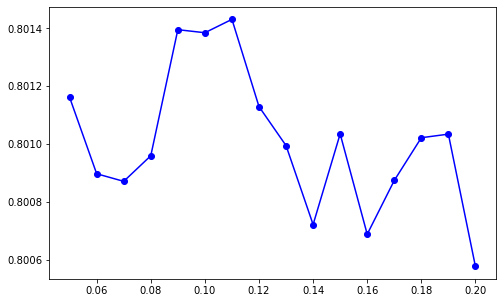

In [178]:
watchlist = [ (train_xgb,'train'), (test_xgb, 'test') ]
# 预测模型评估，调整参数
test_ndcg_score=[]
for i in np.arange(0.05,0.2,0.01):
    params['eta']=i
    # 训练模型
    xgb2 = xgb.train(params,
                train_xgb,
                params['num_round'],
                watchlist,
                feval = customized_eval,# 自定义的评估函数
                verbose_eval = 3,
                early_stopping_rounds = 5)
    y_pred = np.array(xgb2.predict(test_xgb))
    test_ndcg_score.append(ndcg_score(y_test, y_pred, k=k_ndcg))

plt.figure(figsize=(8,5))
plt.plot()
plt.plot(np.arange(0.05,0.2,0.01),test_ndcg_score, 'bo-', label = 'eta')

In [227]:
watchlist = [ (train_xgb,'train'), (test_xgb, 'test') ]
# 训练模型
xgb2 = xgb.train(params,
                train_xgb,
                params['num_round'],
                watchlist,
                feval = customized_eval,# 自定义的评估函数
                verbose_eval = 3,
                early_stopping_rounds = 5)
# 预测模型评估，调整参数
y_pred = np.array(xgb2.predict(test_xgb))
test_score=ndcg_score(y_test, y_pred, k=k_ndcg)
print('test_score',test_score)

[15:17:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.43986	test-merror:0.43718	train-ndcg5:0.79114	test-ndcg5:0.79244
Multiple eval metrics have been passed: 'test-ndcg5' will be used for early stopping.

Will train until test-ndcg5 hasn't improved in 5 rounds.
[3]	train-merror:0.42170	test-merror:0.42047	train-ndcg5:0.79952	test-ndcg5:0.79946
Stopping. Best iteration:
[0]	train-merror:0.43986	test-merror:0.43718	train-ndcg5:0.79114	test-ndcg5:0.79244

test_score 0.8014310200104076


In [274]:
# 预测结果输出文件
xtest = pd.read_csv("Airbnb_xtest_v2.csv",index_col=0)
# 标准化数据集
X_scaler = StandardScaler()
xtest = X_scaler.fit_transform(xtest)

realtest_xgb = xgb.DMatrix(xtest)
predictions = np.array(xgb2.predict(realtest_xgb)) # predictions是一个概率矩阵，将概率最高的视为输出

output=[]
for i in range(predictions.shape[0]):
    output.append(np.argsort(predictions[i])[::-1][:1])
# 逆变换
output=le.inverse_transform(output)

d={"id" : testlabels,
   "country" : output}
pd_data = pd.DataFrame(d)
pd_data.to_csv("result.csv")

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [63]:
# xgboost的sklearn接口
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection,metrics
import xgboost as xgb

# 数据集整理
X_train, X_test, y_train, y_test = train_test_split(xtrain_new,ytrain_new,test_size=0.2,random_state=RANDOM_STATE)
train_xgb = xgb.DMatrix(X_train, label= y_train)
test_xgb = xgb.DMatrix(X_test, label = y_test)

In [64]:
# xgboost的sklearn接口
xgb1 = XGBClassifier(max_depth=7,# 构建树的深度，越大越容易过拟合
                     learning_rate=0.11,# 如同学习率
                     n_estimators=50,#决策树数量
                     silent=False,
                     objective='multi:softprob',# 多分类的问题
                     booster='gbtree',
                     num_class=12,# 类别数，与 multisoftmax 并用
                     n_jobs=4,
                     gamma=0.8,# 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
                     min_child_weight=1,
                     subsample=0.8,# 随机采样训练样本
                     colsample_bytree=0.7,# 生成树时进行的列采样
                     seed=RANDOM_STATE)# 随机种子
xgb1.get_xgb_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': 'gbtree',
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.7,
 'gamma': 0.2,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_delta_step': None,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 70,
 'n_jobs': 4,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': False,
 'verbosity': None,
 'silent': False,
 'num_class': 12,
 'seed': 2017}

In [65]:
# cv调参
cv_result = xgb.cv(xgb1.get_xgb_params(),
                   train_xgb,
                   num_boost_round=xgb1.get_xgb_params()['n_estimators'],
                   nfold=5,
                   #metrics='mlogloss',
                   feval = customized_eval,
                   early_stopping_rounds=5,
                   callbacks=[xgb.callback.early_stop(5),
                              xgb.callback.print_evaluation(period=1,show_stdv=True)])
print(cv_result)

Multiple eval metrics have been passed: 'test-ndcg5' will be used for early stopping.

Will train until test-ndcg5 hasn't improved in 5 rounds.
[0]	train-merror:0.42651+0.00579	test-merror:0.42859+0.00950	train-ndcg5:0.79662+0.00181	test-ndcg5:0.79331+0.00400
[1]	train-merror:0.42251+0.00336	test-merror:0.42529+0.00797	train-ndcg5:0.79902+0.00101	test-ndcg5:0.79499+0.00352
[2]	train-merror:0.41923+0.00256	test-merror:0.42250+0.00608	train-ndcg5:0.80060+0.00100	test-ndcg5:0.79619+0.00271
[3]	train-merror:0.41845+0.00211	test-merror:0.42157+0.00499	train-ndcg5:0.80122+0.00060	test-ndcg5:0.79670+0.00269
[4]	train-merror:0.41674+0.00063	test-merror:0.42032+0.00420	train-ndcg5:0.80204+0.00049	test-ndcg5:0.79710+0.00230
Stopping. Best iteration:
[0]	train-merror:0.42651+0.00579	test-merror:0.42859+0.00950	train-ndcg5:0.79662+0.00181	test-ndcg5:0.79331+0.00400

   train-merror-mean  train-merror-std  test-merror-mean  test-merror-std  \
0           0.426505          0.005791          0.428593

In [66]:
# 预测模型评估
xgb_bst1 = xgb1.fit(X_train,
                    y_train,
                    eval_set=[(X_train,y_train),(X_test, y_test)],
                    eval_metric=customized_eval,# 自定义的评估函数
                   early_stopping_rounds = 5)
y_pred = np.array(xgb_bst1.predict(X_test))
test_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)
print(test_ndcg_score)

[0]	validation_0-merror:0.44146	validation_1-merror:0.44007	validation_0-ndcg5:0.79095	validation_1-ndcg5:0.79193
Multiple eval metrics have been passed: 'validation_1-ndcg5' will be used for early stopping.

Will train until validation_1-ndcg5 hasn't improved in 5 rounds.
[1]	validation_0-merror:0.42846	validation_1-merror:0.42641	validation_0-ndcg5:0.79675	validation_1-ndcg5:0.79692
[2]	validation_0-merror:0.41991	validation_1-merror:0.41899	validation_0-ndcg5:0.80013	validation_1-ndcg5:0.79949
[3]	validation_0-merror:0.42342	validation_1-merror:0.42063	validation_0-ndcg5:0.79914	validation_1-ndcg5:0.79908
[4]	validation_0-merror:0.41778	validation_1-merror:0.41766	validation_0-ndcg5:0.80116	validation_1-ndcg5:0.80059
[5]	validation_0-merror:0.41719	validation_1-merror:0.41634	validation_0-ndcg5:0.80139	validation_1-ndcg5:0.80123
Stopping. Best iteration:
[0]	validation_0-merror:0.44146	validation_1-merror:0.44007	validation_0-ndcg5:0.79095	validation_1-ndcg5:0.79193

0.0030452096509